In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft



# Load in the stuff we saved earlier!


In [2]:
expt = "full-20"


topo = xr.open_dataset(f"/g/data/nm03/ab8992/ttide-inputs/full-40/topog_raw.nc").elevation.load()
topo_transect = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/full-40/bathy_transect.nc").depth.load()
speed = xr.open_mfdataset(f"/g/data/nm03/ab8992/outputs/full-40/output100*/surface.nc").speed.isel(time = 15).load()
# speed = xr.open_mfdataset(f"/g/data/nm03/ab8992/postprocessed/full-20/vorticity/topdown/").speed.mean("time").load()
EFalong = (-1 * xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_forward.nc").EF_forward - xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_backward.nc").EF_backward).load()
EFacross = (xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_crossbeam_forward.nc").EF_forward + xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_crossbeam_backward.nc").EF_backward).load()



EFacross = EFacross.assign_coords({"lon": topo_transect.lon, "lat": topo_transect.lat})
EFalong = EFalong.assign_coords({"lon": topo_transect.lon, "lat": topo_transect.lat})


topo_transect_full = tt.beamgrid(topo,beamlength=1600,xname = "lon",yname = "lat").load()

with xr.open_dataset(f"/g/data/nm03/ab8992/ttide-inputs/full-40/topog_noridge.nc").depth as temp:
    topo_transect_beamless = tt.beamgrid(temp,beamlength=1600,xname = "lon",yname = "lat").load()
with xr.open_dataset(f"/g/data/nm03/ab8992/ttide-inputs/full-40/topog_flattened.nc").depth as temp:
    topo_transect_smooth = tt.beamgrid(temp,beamlength=1600,xname = "lon",yname = "lat").load()


--------------------------------------------------------------------------

  Local host:   gadi-cpu-spr-0428
  Local device: mlx5_0
--------------------------------------------------------------------------


(-55.0, -26.0)

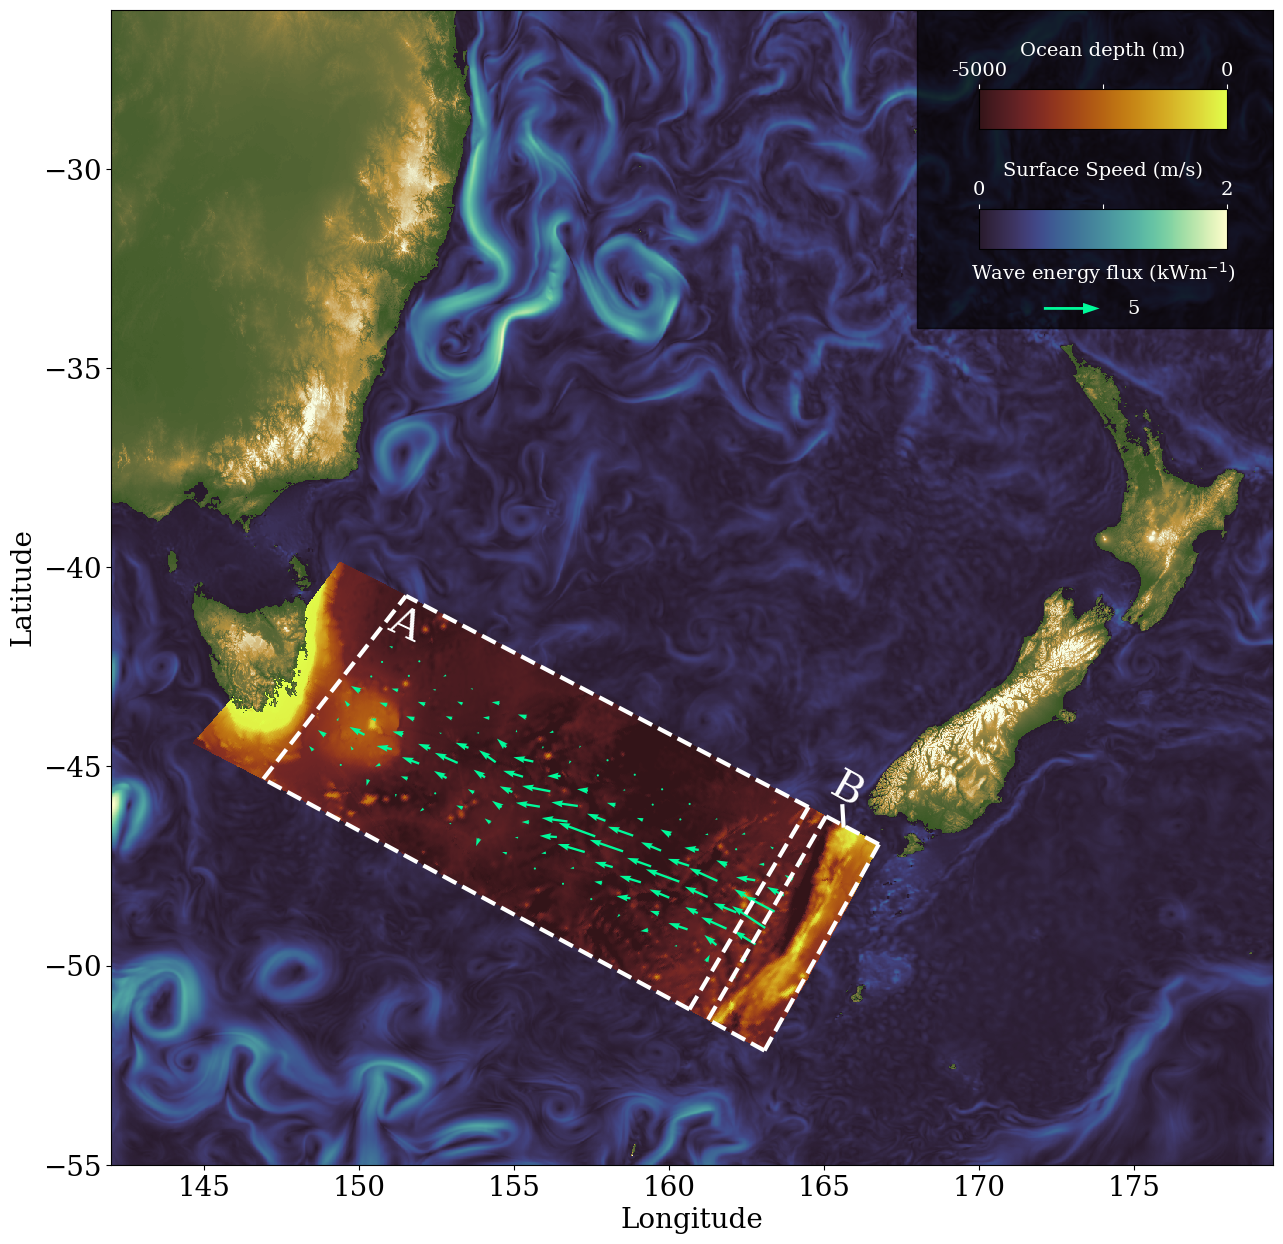

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.gridspec as gridspec
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

speed_cmap = cmocean.cm.deep_r
bathy_cmap = cmocean.cm.solar
EFcolour = "mediumspringgreen"


def plot_KE_quiver(expt,ax,acrossbeam,alongbeam,mode = 0,scale = 3000):
    # np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode").plot(ax = ax)

    xspacing = 20
    yspacing = 8
    angle = -21
    radians = np.deg2rad(angle)
    _along = (alongbeam * np.cos(radians) - acrossbeam * np.sin(radians)).sel(xb = slice(250,None)).isel(mode=mode)[::yspacing, ::xspacing]
    _across = (alongbeam * np.sin(radians) + acrossbeam * np.cos(radians)).sel(xb = slice(250,None)).isel(mode=mode)[::yspacing, ::xspacing]
    # print(expt,np.mean(magnitude.sel(xb = slice(100,175)).values),sep = "\t")

    # Transform xb/yb to lat/lon
    _lon = _along.lon
    _lat = _along.lat

    ax.quiver(_lon, _lat, _along, _across, color=EFcolour, scale=scale,scale_units = "width",width = 0.002)

def plot_topo(ax,bathy = None,transect = None):
    """
    Plot the topography. If transect is not None, plot a transect at the specified yb value
    """

    earth_cmap = cmocean.cm.topo
    earth_cmap.set_bad(color = "white",alpha = 0)
    bathy.where(bathy > 0).plot(cmap = earth_cmap,vmin = -2500,vmax = 1500,ax = ax,add_colorbar = False)
    return ax


fig,ax = plt.subplots(1,figsize = (15,15))


# EFalong.isel(mode = 0).plot(ax = ax,x = "lon",y = "lat")

speed.fillna(0).plot(ax = ax,add_colorbar = False, cmap = speed_cmap, vmin = 0, vmax = None)

topo_transect_full.plot(ax = ax,x = "lon",y = "lat",add_colorbar = False, cmap = bathy_cmap,vmin = -5000,vmax = 0)
lon = topo_transect_full.lon
lat = topo_transect_full.lat
# Plot a line from (155,-40) to (160,-40)

lw = 3

#! Plot the beam path rectangle
left = 200
right = 1400
ax.plot(
    [lon.sel(xb = left,method = "nearest").isel(yb = 0).values,lon.sel(xb = left,method = "nearest").isel(yb = -1).values ],
    [lat.sel(xb = left,method = "nearest").isel(yb = 0).values,lat.sel(xb = left,method = "nearest").isel(yb = -1).values ],
    color='white', linewidth = lw,linestyle='--')

ax.plot(
    [lon.sel(xb = right,method = "nearest").isel(yb = 0).values,lon.sel(xb = right,method = "nearest").isel(yb = -1).values ],
    [lat.sel(xb = right,method = "nearest").isel(yb = 0).values,lat.sel(xb = right,method = "nearest").isel(yb = -1).values ],
    color='white', linewidth = lw,linestyle='--')

ax.plot(
    [lon.sel(xb = right,method = "nearest").isel(yb = 0).values,lon.sel(xb = left,method = "nearest").isel(yb = 0).values ],
    [lat.sel(xb = right,method = "nearest").isel(yb = 0).values,lat.sel(xb = left,method = "nearest").isel(yb = 0).values ],
    color='white', linewidth = lw,linestyle='--')


ax.plot(
    [lon.sel(xb = right,method = "nearest").isel(yb = -1).values,lon.sel(xb = left,method = "nearest").isel(yb = -1).values ],
    [lat.sel(xb = right,method = "nearest").isel(yb = -1).values,lat.sel(xb = left,method = "nearest").isel(yb = -1).values ],
    color='white', linewidth = lw,linestyle='--')

ax.text(lon.sel(xb = left + 20,yb = 105,method = "nearest").values, 
        lat.sel(xb = left + 20,yb = 105,method = "nearest").values,
        "A",
        color = "white",
        rotation = -25,
        fontsize = 30)


#! Plot the beam ridge rectangle
left = 1450
right = 10000
ax.plot(
    [lon.sel(xb = left,method = "nearest").isel(yb = 0).values,lon.sel(xb = left,method = "nearest").isel(yb = -1).values ],
    [lat.sel(xb = left,method = "nearest").isel(yb = 0).values,lat.sel(xb = left,method = "nearest").isel(yb = -1).values ],
    color='white', linewidth = lw,linestyle='--')

ax.plot(
    [lon.sel(xb = right,method = "nearest").isel(yb = 0).values,lon.sel(xb = right,method = "nearest").isel(yb = -1).values ],
    [lat.sel(xb = right,method = "nearest").isel(yb = 0).values,lat.sel(xb = right,method = "nearest").isel(yb = -1).values ],
    color='white', linewidth = lw,linestyle='--')

ax.plot(
    [lon.sel(xb = right,method = "nearest").isel(yb = 0).values,lon.sel(xb = left,method = "nearest").isel(yb = 0).values ],
    [lat.sel(xb = right,method = "nearest").isel(yb = 0).values,lat.sel(xb = left,method = "nearest").isel(yb = 0).values ],
    color='white', linewidth = lw,linestyle='--')


ax.plot(
    [lon.sel(xb = right,method = "nearest").isel(yb = -1).values,lon.sel(xb = left,method = "nearest").isel(yb = -1).values ],
    [lat.sel(xb = right,method = "nearest").isel(yb = -1).values,lat.sel(xb = left,method = "nearest").isel(yb = -1).values ],
    color='white', linewidth = lw,linestyle='--')


plot_topo(ax = ax,bathy = topo)
ax.text(165,
        -46,
        "B",
        ma = "center",
        color = "white",
        rotation = -29,
        fontsize = 30)

## Add line from letter B to zone B
ax.plot(
    [lon.sel(xb = 1500,method = "nearest").isel(yb = -1).values,165.6],
    [lat.sel(xb = 1500,method = "nearest").isel(yb = -1).values,-46],
    color='white', linewidth = lw)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# EFacross.isel(mode = 0).plot(ax = ax,x = "lon",y = "lat",add_colorbar = False,cmap = cmocean.cm.speed)
plot_KE_quiver(expt,ax,EFacross,EFalong,mode = 0,scale = 3000)

## Add inset axis for colourbars:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#! Dodgy axis inset


cax1 = ax.inset_axes([170, -29, 8, 1],transform=ax.transData)  # Adjust size and location
cax2 = ax.inset_axes([170, -32, 8, 1],transform=ax.transData)  # Adjust size and location

# Add a white patch to ax underneath these colourbar axes
ax.add_patch(matplotlib.patches.Rectangle((168, -34), 12, 10, color='black', alpha=0.7))

ax.annotate('', xy=(174, -33.5), xytext=(172, -33.5),
            arrowprops=dict(facecolor=EFcolour, shrink=0.05, width=2, headwidth=8, edgecolor="none"))

ax.text(175, -33.5, "5", color = "white", fontsize = 14, ha = "center", va = "center")


ax.text(174, -32.6, r"Wave energy flux (kWm$^{-1}$)", color = "white", fontsize = 14, ha = "center", va = "center")

cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmocean.cm.solar, norm=plt.Normalize(vmin=0, vmax=1)),
    cax=cax1,
    orientation='horizontal',
    location = "top",
    label = "Ocean depth (m)",
)

cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmocean.cm.deep_r, norm=plt.Normalize(vmin=0, vmax=1)),
    cax=cax2,
    orientation='horizontal',
    location = "top",
    label = "Surface Speed (m/s)",
)



cax1.set_xticks([0, 0.5,1])
cax2.set_xticks([0, 0.5,1])
cax1.set_xticklabels([-5000,None, 0])
cax2.set_xticklabels([0,None, 2])
cax1.tick_params(labelsize=14, color="white", labelcolor="white")  # Set font size and color for colorbar ticks
cax1.xaxis.label.set_size(14)  # Set font size for colorbar label
cax1.xaxis.label.set_color("white")  # Set label color to white

cax2.tick_params(labelsize=14, color="white", labelcolor="white")  # Set font size and color for colorbar ticks
cax2.xaxis.label.set_size(14)  # Set font size for colorbar label
cax2.xaxis.label.set_color("white")  # Set label color to white

ax.set_xlim(None, 179.5)
ax.set_ylim(-55,None)

In [36]:
np.sqrt(np.max(EFacross**2 + EFalong**2))

<xarray.DataArray ()> Size: 8B
array(154.54810072)
Coordinates:
    zi       float64 8B 10.79

## Andy's version

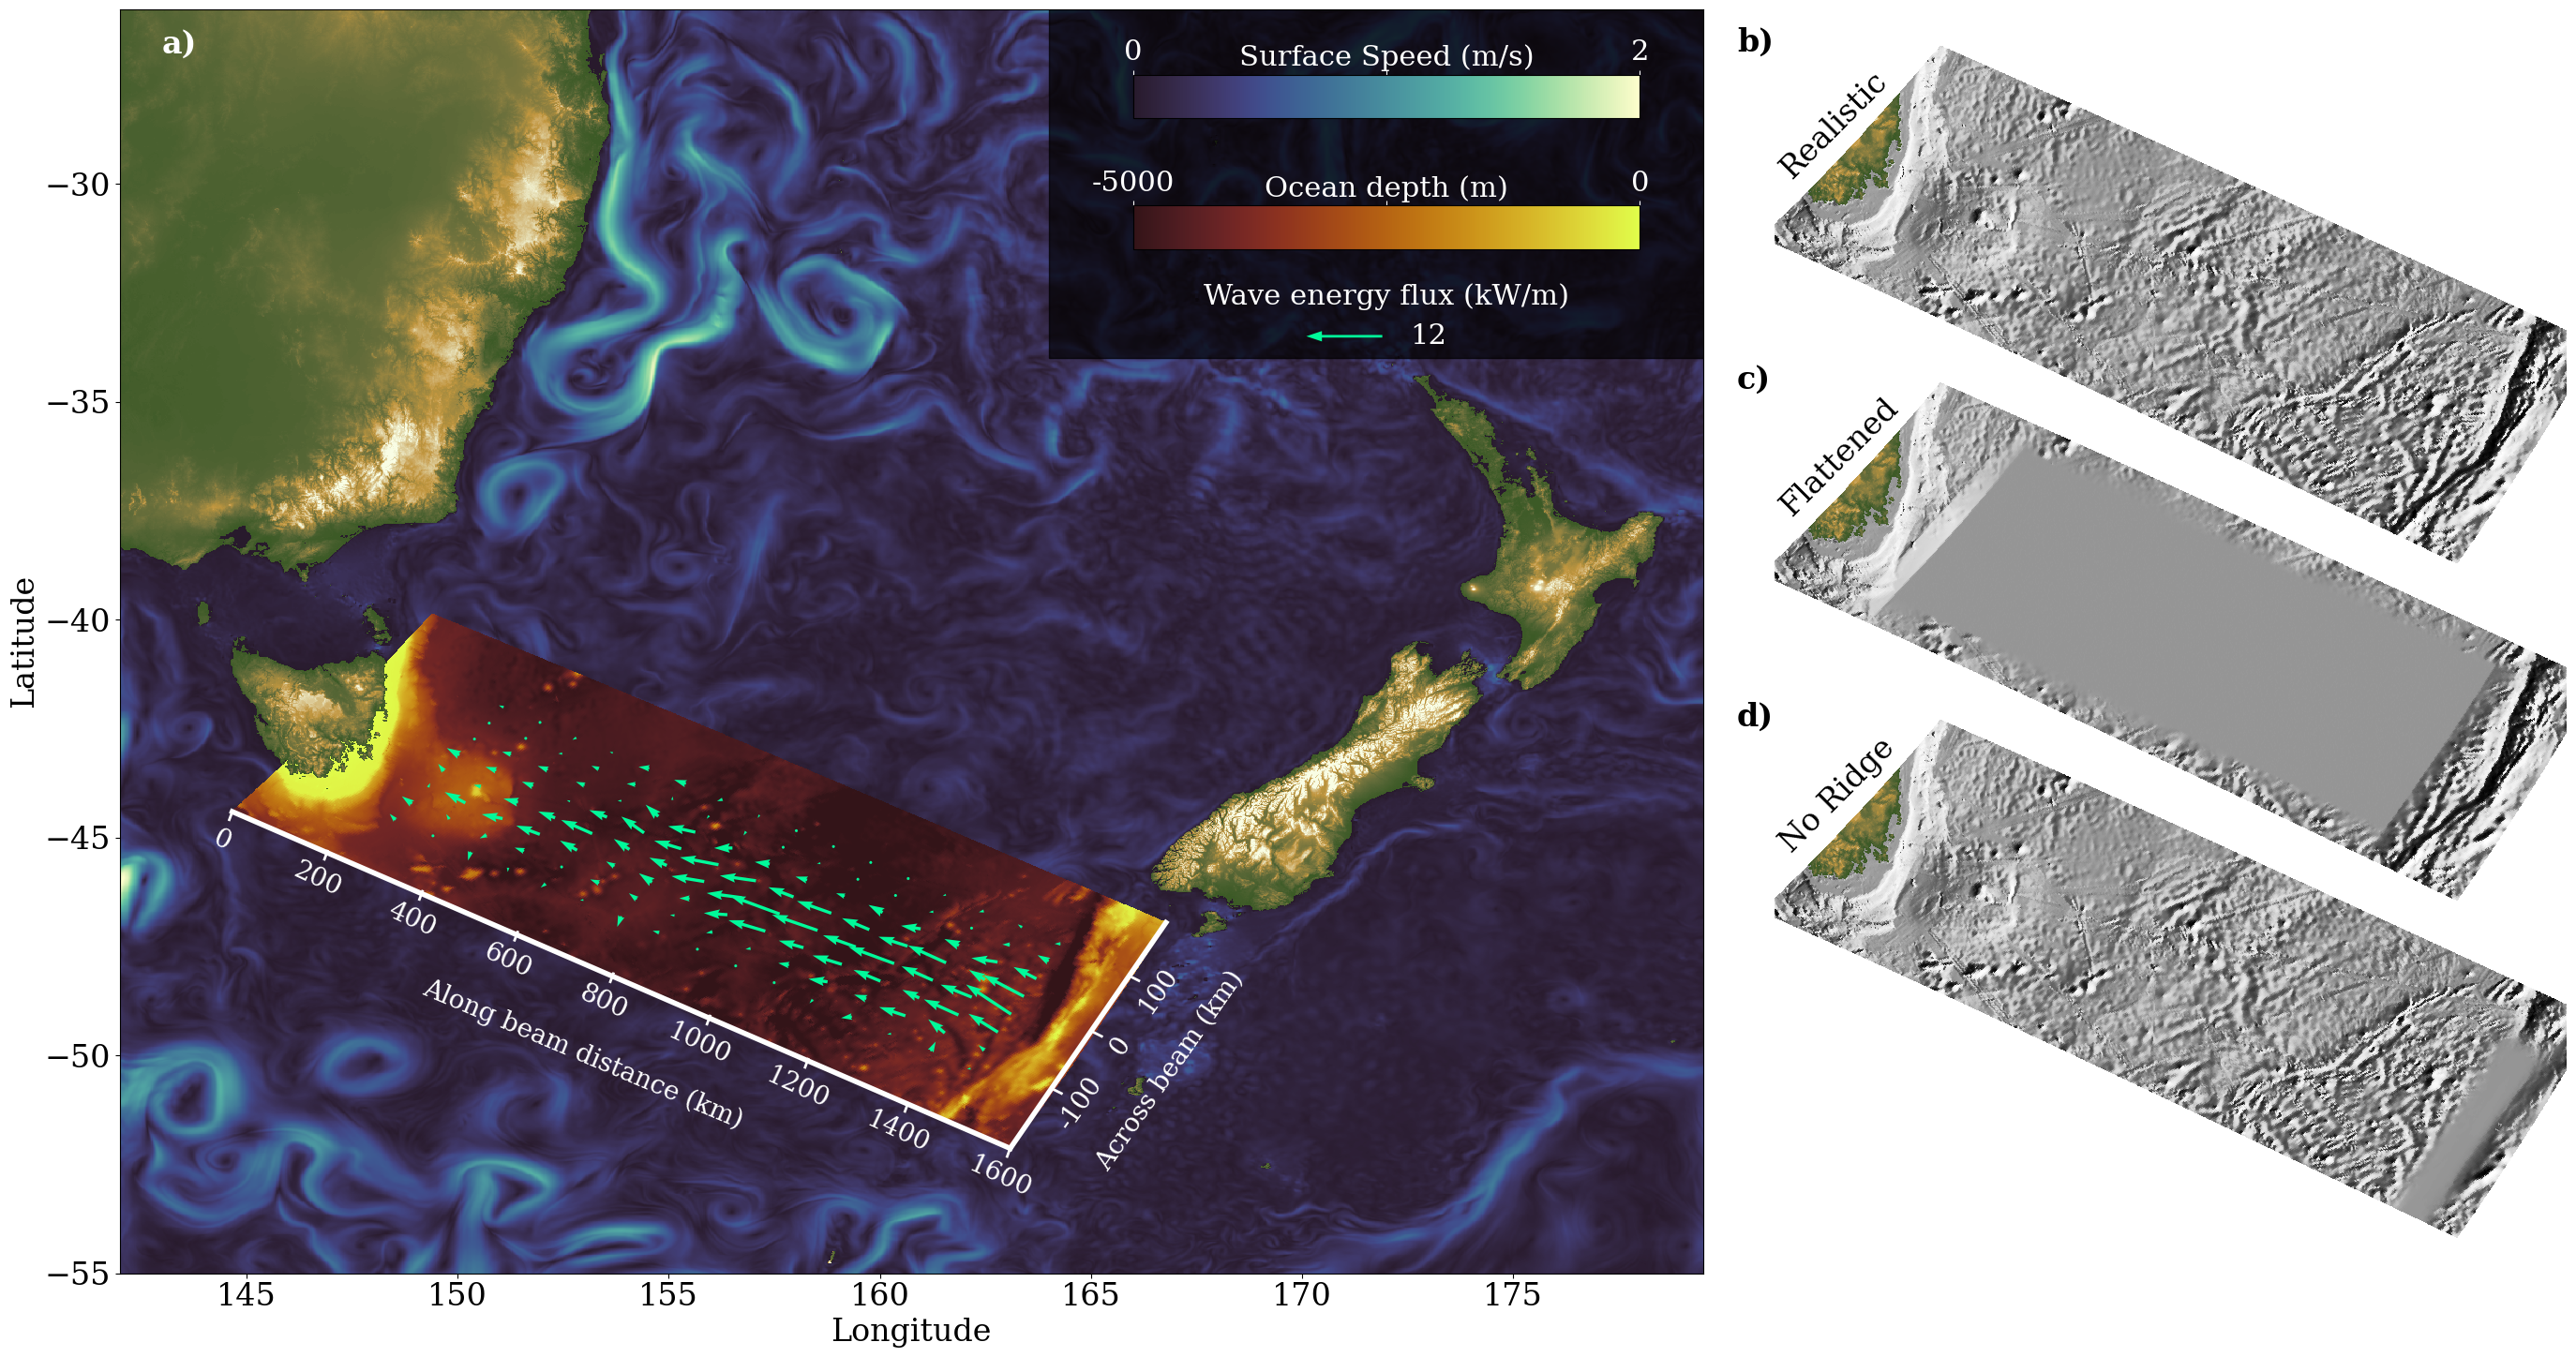

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.gridspec as gridspec
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 24}
matplotlib.rc('font', **font)

speed_cmap = cmocean.cm.deep_r
bathy_cmap = cmocean.cm.solar
EFcolour = "mediumspringgreen"


def plot_KE_quiver(expt,ax,acrossbeam,alongbeam,mode = 0,scale = 3000):
    # np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode").plot(ax = ax)

    xspacing = 20
    yspacing = 8
    angle = -21
    radians = np.deg2rad(angle)
    _along = (alongbeam * np.cos(radians) - acrossbeam * np.sin(radians)).sel(xb = slice(250,None)).isel(mode=mode)[::yspacing, ::xspacing]
    _across = (alongbeam * np.sin(radians) + acrossbeam * np.cos(radians)).sel(xb = slice(250,None)).isel(mode=mode)[::yspacing, ::xspacing]
    # print(expt,np.mean(magnitude.sel(xb = slice(100,175)).values),sep = "\t")

    # Transform xb/yb to lat/lon
    _lon = _along.lon
    _lat = _along.lat

    ax.quiver(_lon, _lat, _along, _across, color=EFcolour, scale=scale,scale_units = "width",width = 0.002)

def plot_topo(ax,bathy = None,transect = None):
    """
    Plot the topography. If transect is not None, plot a transect at the specified yb value
    """

    earth_cmap = cmocean.cm.topo
    earth_cmap.set_bad(color = "white",alpha = 0)
    bathy.where(bathy > 0).plot(cmap = earth_cmap,vmin = -2500,vmax = 1500,ax = ax,add_colorbar = False,x = "lon",y = "lat")
    return ax


fig = plt.figure(figsize=(28, 15))

gs = gridspec.GridSpec(1, 2,  width_ratios=[2, 1])
ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
# ax3 = fig.add_subplot(gs[1])

# EFalong.isel(mode = 0).plot(ax = ax,x = "lon",y = "lat")

speed.fillna(0).plot(ax = ax,add_colorbar = False, cmap = speed_cmap, vmin = 0, vmax = None)

topo_transect_full.plot(ax = ax,x = "lon",y = "lat",add_colorbar = False, cmap = bathy_cmap,vmin = -5000,vmax = 0)
lon = topo_transect_full.lon
lat = topo_transect_full.lat
# Plot a line from (155,-40) to (160,-40)

lw = 3

plot_topo(ax = ax,bathy = topo)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# EFacross.isel(mode = 0).plot(ax = ax,x = "lon",y = "lat",add_colorbar = False,cmap = cmocean.cm.speed)
plot_KE_quiver(expt,ax,EFacross,EFalong,mode = 0,scale = 3000)

## Add inset axis for colourbars:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cax2 = ax.inset_axes([166, -28.5, 12, 1],transform=ax.transData)  # Adjust size and location
cax1 = ax.inset_axes([166, -31.5, 12, 1],transform=ax.transData)  # Adjust size and location

# Add a white patch to ax underneath these colourbar axes
ax.add_patch(matplotlib.patches.Rectangle((164, -34), 16, 10, color='black', alpha=0.7))

ax.annotate('', xy=(170, -33.5), xytext=(172, -33.5),
            arrowprops=dict(facecolor=EFcolour, shrink=0.05, width=2, headwidth=8, edgecolor="none"))

ax.text(173, -33.5, "12", color = "white", fontsize = 22, ha = "center", va = "center")


ax.text(172, -32.6, r"Wave energy flux (kW/m)", color = "white", fontsize = 22, ha = "center", va = "center")

cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmocean.cm.solar, norm=plt.Normalize(vmin=0, vmax=1)),
    cax=cax1,
    orientation='horizontal',
    location = "top",
    label = "Ocean depth (m)",
)

cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmocean.cm.deep_r, norm=plt.Normalize(vmin=0, vmax=1)),
    cax=cax2,
    orientation='horizontal',
    location = "top",
    label = "Surface Speed (m/s)",
)

cax1.xaxis.set_label_coords(0.5, 1.2)
cax2.xaxis.set_label_coords(0.5, 1.2)

cax1.set_xticks([0, 0.5,1])
cax2.set_xticks([0, 0.5,1])
cax1.set_xticklabels([-5000,None, 0])
cax2.set_xticklabels([0,None, 2])
cax1.tick_params(labelsize=22, color="white", labelcolor="white")  # Set font size and color for colorbar ticks
cax1.xaxis.label.set_size(22)  # Set font size for colorbar label
cax1.xaxis.label.set_color("white")  # Set label color to white

cax2.tick_params(labelsize=22, color="white", labelcolor="white")  # Set font size and color for colorbar ticks
cax2.xaxis.label.set_size(22)  # Set font size for colorbar label
cax2.xaxis.label.set_color("white")  # Set label color to white

ax.set_xlim(None, 179.5)
ax.set_ylim(-55,None)

vspacing = 8
voffset = 5
import matplotlib.colors as colors
vmin = -300
vmax = 300
norm = colors.SymLogNorm(linthresh=5, linscale=0.2,vmin = -vmax,vmax = vmax,)

bathy_cmap = "Grays"

(-1 * topo_transect_beamless.differentiate("xb").fillna(0).assign_coords(
    {"lat":topo_transect_full.lat - vspacing + voffset}
)).plot(ax = ax2,add_colorbar = False,norm = norm, cmap = bathy_cmap,x = "lon",y = "lat")
(-1 * topo_transect_smooth.differentiate("xb").fillna(0).assign_coords(
    {"lat":topo_transect_full.lat + voffset}
)).plot(ax = ax2,add_colorbar = False,norm = norm, cmap = bathy_cmap,x = "lon",y = "lat")
(topo_transect_full.differentiate("xb").fillna(0).assign_coords(
    {"lat":topo_transect_full.lat + vspacing + voffset}
)).plot(ax = ax2,add_colorbar = False,norm = norm, cmap = bathy_cmap,x = "lon",y = "lat")

ax2.set_xlim(145,166)
ax2.set_ylim(-56,-26)
plot_topo(ax = ax2,bathy = topo_transect_full.assign_coords(
    {"lat":topo_transect_full.lat - vspacing + voffset}
))
plot_topo(ax = ax2,bathy = topo_transect_full.assign_coords(
    {"lat":topo_transect_full.lat + vspacing + voffset}
))
plot_topo(ax = ax2,bathy = topo_transect_full.assign_coords(
    {"lat":topo_transect_full.lat + voffset}
))
# plot_topo(ax = ax3,bathy = topo_transect_full)


# Artificial x axis

ax.plot(
    [lon.sel(xb = 0,method = "nearest").isel(yb = 0).values,lon.sel(xb = 1600,method = "nearest").isel(yb = 0).values],
    [lat.sel(xb = 0,method = "nearest").isel(yb = 0).values,lat.sel(xb = 1600,method = "nearest").isel(yb = 0).values],
    color = "white",lw = 4
)
for i in [0,200,400,600,800,1000,1200,1400,1600]:
    y0 = lat.sel(xb = i,method = "nearest").isel(yb = 0).values
    x0 = lon.sel(xb = i,method = "nearest").isel(yb = 0).values
    ax.text(
        x0 + 0.7 * np.sin(np.deg2rad(-21)),
        y0 - 0.7 * np.cos(np.deg2rad(-21)),
        str(i),
        ha = "center",
        va = "center",
        color = "white",
        rotation = -25,
        fontsize = 20
    )
    ax.plot(
        [x0,x0 + 0.2 * np.sin(np.deg2rad(-21))],
        [y0,y0 - 0.2 * np.cos(np.deg2rad(-21))],
        color='white', linewidth = 2
    )
    if i == 800:
        ax.text(
        x0 + 2 * np.sin(np.deg2rad(-21)),
        y0 - 2 * np.cos(np.deg2rad(-21)),
        "Along beam distance (km)",
        ha = "center",
        va = "center",
        color = "white",
        rotation = -23,
        fontsize = 20
    )


# Artificial y axis
ax.plot(
    [lon.sel(xb = 1600,method = "nearest").isel(yb = 0).values,lon.sel(xb = 1600,method = "nearest").isel(yb = -1).values],
    [lat.sel(xb = 1600,method = "nearest").isel(yb = 0).values,lat.sel(xb = 1600,method = "nearest").isel(yb = -1).values],
    color = "white",lw = 4
)
for i in [-100,0,100]:
    y0 = lat.sel(yb = i,method = "nearest").isel(xb = -1).values
    x0 = lon.sel(yb = i,method = "nearest").isel(xb = -1).values
    x_angle = np.cos(np.deg2rad(26))
    y_angle = np.sin(np.deg2rad(-26))

    ax.text(
        x0 + x_angle * 0.7,
        y0 + y_angle * 0.7,
        str(i),
        ha = "center",
        va = "center",
        color = "white",
        rotation = 55,
        fontsize = 20
    )
    ax.plot(
        [x0,x0 + x_angle * 0.2],
        [y0,y0 + y_angle * 0.2],
        color='white', linewidth = 2
    )
    if i == 0:
        ax.text(
        x0 + 2 * x_angle,   
        y0 + 2 * y_angle,   
        "Across beam (km)",
        ha = "center",
        va = "center",
        color = "white",
        rotation = 55,
        fontsize = 20
    )

ax2.axis('off')
ax2.text(144,-40 + vspacing + voffset,"b)",fontweight = "bold",fontsize = 24)
ax2.text(144,-40 + voffset,"c)",fontweight = "bold",fontsize = 24)
ax2.text(144,-40 - vspacing + voffset,"d)",fontweight = "bold",fontsize = 24)

ax2.text(145,-43 + vspacing + voffset,"Realistic",rotation = 45)
ax2.text(145,-43 + voffset,"Flattened",rotation = 45)
ax2.text(145,-43 - vspacing + voffset,"No Ridge",rotation = 45)


ax.text(143,-27,"a)",color = "white",fontweight = "bold",fontsize = 24)

fig.set_tight_layout(True)
# ticks = [-300,0,300]
# cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=bathy_cmap),ax = ax2,label = f"Bathymetry gradient (m/km)",orientation = "horizontal",location = "bottom")
# cbar.set_ticks(ticks)



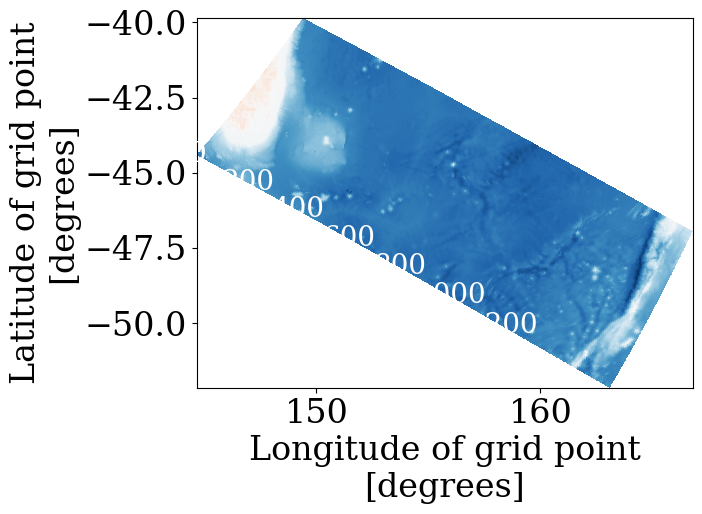

In [35]:
topo_transect_full.plot(x = "lon",y = "lat",add_colorbar = False)
for i in [0,200,400,600,800,1000,1200]:
    plt.text(
        lon.sel(xb = i,method = "nearest").isel(yb = 0).values,
        lat.sel(xb = i,method = "nearest").isel(yb = 0).values,
        str(i),
        color = "white",
        rotation = 0,
        ha = "center",
        va = "center",
        fontsize = 20
    )
